In [1]:
import numpy as np
import pandas as pd
import glob
import os
import sys
PROJECT_REPO_DIR = os.path.abspath('../PC-HMM')
sys.path.append(PROJECT_REPO_DIR)
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'pcvae'))

from pcvae.datasets.toy import toy_line, custom_dataset, custom_regression_dataset
from pcvae.models.hmm import HMM
from pcvae.datasets.base import dataset, real_dataset, classification_dataset, make_dataset

import matplotlib.pyplot as plt

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score)

import seaborn as sns
# sys.path.append(os.path.abspath('../PC-HMM/'))
# from main_mimic_semi_supervised_ordinal import compute_binary_classification_perf
%matplotlib inline

In [2]:
PROJECT_REPO_DIR

'/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/PC-HMM'

## Print performance and plot the PRC to make sure

test AUPRC of best model for LOS classification > 3 days: 0.704
test AUC of best model for LOS classification > 3 days : 0.718
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=87421-init_strategy=kmeans-batch_size=128-min_los=3-predictor_l2_penalty=0-n_states=5-lamb=50-weights.h5
Class dist 0.471779199694394


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


Training data shape: (10471, 1, 24, 41)
test AUPRC of best model for LOS classification > 7 days: 0.387
test AUC of best model for LOS classification > 7 days : 0.766
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=12-init_strategy=kmeans-batch_size=128-min_los=7-predictor_l2_penalty=0-n_states=5-lamb=500-weights.h5
Class dist 0.1657912329290421
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


test AUPRC of best model for LOS classification > 11 days: 0.230
test AUC of best model for LOS classification > 11 days : 0.763
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=5-init_strategy=kmeans-batch_size=512-min_los=11-predictor_l2_penalty=0-n_states=5-lamb=5000-weights.h5
Class dist 0.08528316302167892
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


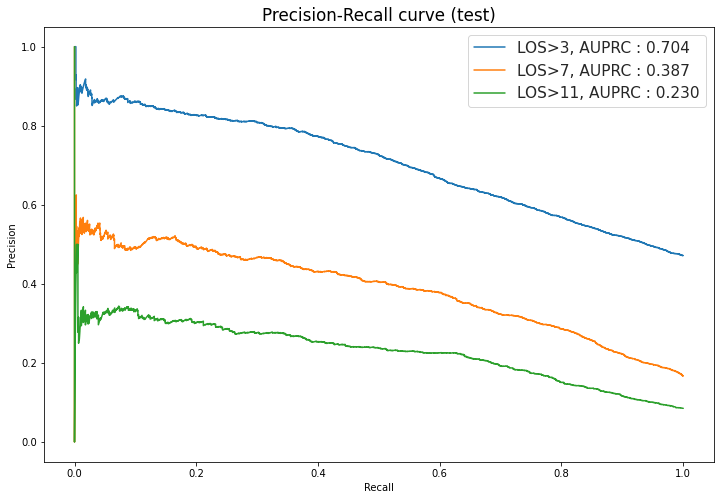

In [3]:
bc_perf_dict_list = []
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/'
f, axs = plt.subplots(1, 1, figsize=(12, 8))
y_test_pred_proba_list = []


for min_los in [3, 7, 11]:

    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_classification/final_perf*min_los=%d*.csv'%min_los))

    perf_csvs = [ii for ii in perf_csvs if 'perc_labelled' not in ii]
    
    
    valid_auprc_np = np.zeros(len(perf_csvs))
    test_auprc_np = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
        test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

    # curr_perf_df
    best_ind = np.argmax(valid_auprc_np)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]

    print('test AUPRC of best model for LOS classification > %d days: %.3f'%(min_los, 
                                                                             perf_df['test_AUPRC'].values[-1]))
    print('test AUC of best model for LOS classification > %d days : %.3f'%(min_los, 
                                                                            perf_df['test AUC'].values[-1]))
    
    
    
    x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH,  'los_geq_%d_days_prediction'%min_los,'X_test.npy')
    y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH,  'los_geq_%d_days_prediction'%min_los,'y_test.npy')

    best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')
    
    print('best_model : %s'%best_model_weights)
    X_test = np.load(x_test_np_filename)
    y_test = np.load(y_test_np_filename)


    X_test = np.expand_dims(X_test, 1)

    # standardize data for PC-HMM
    key_list = ['train', 'valid', 'test']
    data_dict = dict.fromkeys(key_list)
    data_dict['train'] = (X_test, y_test)
    data_dict['valid'] = (X_test, y_test)
    data_dict['test'] = (X_test, y_test)
    data = custom_dataset(data_dict=data_dict)

    # load the best PCHMM model
    model = HMM(states=5,
                observation_dist='NormalWithMissing',
                predictor_dist='Categorical')

    model.build(data)
    model.model.load_weights(best_model_weights)

    x_test, y_test = data.test().numpy()
    z_test = model.hmm_model.predict(x_test)
    y_test_pred_proba = model._predictor.predict(z_test)
    labelled_inds_te = ~np.isnan(y_test[:,0])
    test_roc_auc = roc_auc_score(y_test[labelled_inds_te], y_test_pred_proba[labelled_inds_te])
    test_auprc = average_precision_score(y_test[labelled_inds_te, 1], y_test_pred_proba[labelled_inds_te, 1])
    
    
    bc_perf_dict_list.append({'min_los' : min_los,
                             'perc_labelled' : '100',
                             'test_AUC' : test_roc_auc,
                             'test_AUPRC' : test_auprc})
    
    y_test_pred_proba_list.append(y_test_pred_proba[:, 1])
    
    sns.set_context('notebook', font_scale=1.4)
    sns.set_style('whitegrid')
    precision, recall, thresholds = precision_recall_curve(y_test[:, 1], y_test_pred_proba[:, 1])
    axs.plot(recall, precision, label='LOS>%d, AUPRC : %.3f'%(min_los, test_auprc))
    axs.set_ylabel("Precision")
    axs.set_xlabel("Recall")
    axs.set_title("Precision-Recall curve (test)")
    axs.legend()
plt.show()
    

## Show some examples of p(LOS(x)>11 days) > p(LOS(x)>3 days) for some examples

In [4]:
pred_proba_df = pd.DataFrame(np.vstack(y_test_pred_proba_list).T, columns=['p(LOS>3)', 'p(LOS>7)', 'p(LOS>11)'])
# pred_proba_df

keep_inds = pred_proba_df['p(LOS>3)']<pred_proba_df['p(LOS>11)']

print(pred_proba_df.loc[keep_inds].reset_index(drop=True)[:50].round(3))

    p(LOS>3)  p(LOS>7)  p(LOS>11)
0      0.446     0.373      0.489
1      0.175     0.657      0.446
2      0.664     0.484      0.857
3      0.036     0.619      0.481
4      0.108     0.432      0.271
5      0.534     0.761      0.656
6      0.334     0.581      0.457
7      0.233     0.779      0.723
8      0.064     0.630      0.182
9      0.020     0.282      0.054
10     0.001     0.424      0.287
11     0.085     0.568      0.301
12     0.074     0.236      0.256
13     0.304     0.439      0.361
14     0.626     0.777      0.676
15     0.009     0.561      0.215


## Get performance of PC-HMM classification as a function of % labelled sequences

In [5]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3']

for min_los in [3, 7, 11]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_classification/final_perf*min_los=%d*perc_labelled=%s*.csv'%(min_los, perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
            test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

        # curr_perf_df
        best_ind = np.argmax(valid_auprc_np)
        perf_df = pd.read_csv(perf_csvs[best_ind])
        best_model_perf_csv = perf_csvs[best_ind]

#         print('test AUPRC of best model for LOS classification > %d days: %.3f'%(min_los, 
#                                                                                  perf_df['test_AUPRC'].values[-1]))
#         print('test AUC of best model for LOS classification > %d days : %.3f'%(min_los, 
#                                                                                 perf_df['test AUC'].values[-1]))



        x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH,  'los_geq_%d_days_prediction'%min_los,'X_test.npy')
        y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH,  'los_geq_%d_days_prediction'%min_los,'y_test.npy')

        best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

        print('best_model : %s'%best_model_weights)
        X_test = np.load(x_test_np_filename)
        y_test = np.load(y_test_np_filename)


        X_test = np.expand_dims(X_test, 1)

        # standardize data for PC-HMM
        key_list = ['train', 'valid', 'test']
        data_dict = dict.fromkeys(key_list)
        data_dict['train'] = (X_test, y_test)
        data_dict['valid'] = (X_test, y_test)
        data_dict['test'] = (X_test, y_test)
        data = custom_dataset(data_dict=data_dict)

        # load the best PCHMM model
        model = HMM(states=5,
                    observation_dist='NormalWithMissing',
                    predictor_dist='Categorical')

        model.build(data)
        model.model.load_weights(best_model_weights)

        x_test, y_test = data.test().numpy()
        z_test = model.hmm_model.predict(x_test)
        y_test_pred_proba = model._predictor.predict(z_test)
        labelled_inds_te = ~np.isnan(y_test[:,0])
        test_roc_auc = roc_auc_score(y_test[labelled_inds_te], y_test_pred_proba[labelled_inds_te])
        test_auprc = average_precision_score(y_test[labelled_inds_te, 1], y_test_pred_proba[labelled_inds_te, 1])

        bc_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

bc_perf_df = pd.DataFrame(bc_perf_dict_list)

best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.001-seed=19-init_strategy=kmeans-batch_size=128-min_los=3-predictor_l2_penalty=0-perc_labelled=1.2-n_states=5-lamb=5000-weights.h5
Class dist 0.471779199694394
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.527
test AUROC : 0.539
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=107-init_strategy=kmeans-batch_size=128-min_los=3-predictor_l2_penalty=0-perc_labelled=3.7-n_states=5-lamb=1000-weights.h5
Class dist 0.471779199694394
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.627
test AUROC : 0.659
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=17-init_strategy=kmeans-batch_size=128-min_los=3-predictor_l2_penalty=0-perc_labelled=11.1-n_states=5-lamb=50-weights.h5
Class dist 0.471779199694394
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.666
test AUROC : 0.696
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=107-init_strategy=kmeans-batch_size=128-min_los=3-predictor_l2_penalty=0-perc_labelled=33.3-n_states=5-lamb=100-weights.h5
Class dist 0.471779199694394
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.686
test AUROC : 0.711
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.001-seed=28-init_strategy=kmeans-batch_size=512-min_los=7-predictor_l2_penalty=0-perc_labelled=1.2-n_states=5-lamb=500-weights.h5
Class dist 0.1657912329290421
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 7 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.266
test AUROC : 0.618
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=107-init_strategy=kmeans-batch_size=128-min_los=7-predictor_l2_penalty=0-perc_labelled=3.7-n_states=5-lamb=100-weights.h5
Class dist 0.1657912329290421
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 7 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.299
test AUROC : 0.683
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=214-init_strategy=kmeans-batch_size=1024-min_los=7-predictor_l2_penalty=0-perc_labelled=11.1-n_states=5-lamb=100-weights.h5
Class dist 0.1657912329290421
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 7 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.341
test AUROC : 0.714
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=107-init_strategy=kmeans-batch_size=128-min_los=7-predictor_l2_penalty=0-perc_labelled=33.3-n_states=5-lamb=50-weights.h5
Class dist 0.1657912329290421
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 7 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.364
test AUROC : 0.729
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.001-seed=214-init_strategy=kmeans-batch_size=1024-min_los=11-predictor_l2_penalty=0-perc_labelled=1.2-n_states=5-lamb=500-weights.h5
Class dist 0.08528316302167892
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 11 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.146
test AUROC : 0.621
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=17-init_strategy=kmeans-batch_size=1024-min_los=11-predictor_l2_penalty=0-perc_labelled=3.7-n_states=5-lamb=100-weights.h5
Class dist 0.08528316302167892
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 11 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.168
test AUROC : 0.679
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=28-init_strategy=kmeans-batch_size=128-min_los=11-predictor_l2_penalty=0-perc_labelled=11.1-n_states=5-lamb=50-weights.h5
Class dist 0.08528316302167892
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 11 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.193
test AUROC : 0.709
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.01-seed=175-init_strategy=kmeans-batch_size=128-min_los=11-predictor_l2_penalty=0-perc_labelled=33.3-n_states=5-lamb=50-weights.h5
Class dist 0.08528316302167892
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


================LOS > 11 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.223
test AUROC : 0.752


## Evaluate performance for ordinal regression

In [6]:
def compute_binary_classification_perf(y, y_pred_proba_NC):
    # Get the predicted probabilities of los>=3 days
    y_pred_proba_N3 = np.sum(y_pred_proba_NC[:, 1:], axis=1)
    
    # get the true labels for los>=3 days
    y_N3 = (y>=1)*1
    
    # Get the predicted probabilities of los>=7 days
    y_pred_proba_N7 = np.sum(y_pred_proba_NC[:, 2:], axis=1)
    
    # get the true labels for los>=7 days
    y_N7 = (y>=2)*1
    
    # Get the predicted probabilities of los>=11 days
    y_pred_proba_N11 = y_pred_proba_NC[:, 3]
    
    # get the true labels for los>=7 days
    y_N11 = (y==3)*1
    
    labelled_inds = ~np.isnan(y)
    auprc_3 = average_precision_score(y_N3[labelled_inds], y_pred_proba_N3[labelled_inds])
    roc_auc_3 = roc_auc_score(y_N3[labelled_inds], y_pred_proba_N3[labelled_inds])
    
    auprc_7 = average_precision_score(y_N7[labelled_inds], y_pred_proba_N7[labelled_inds])
    roc_auc_7 = roc_auc_score(y_N7[labelled_inds], y_pred_proba_N7[labelled_inds])
    
    auprc_11 = average_precision_score(y_N11[labelled_inds], y_pred_proba_N11[labelled_inds])
    roc_auc_11 = roc_auc_score(y_N11[labelled_inds], y_pred_proba_N11[labelled_inds])
    
    return y_N3, y_pred_proba_N3, auprc_3, roc_auc_3, y_N7, y_pred_proba_N7, auprc_7, roc_auc_7, y_N11, y_pred_proba_N11, auprc_11, roc_auc_11

Class dist 0.7228535956451151
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


test AUPRC of best model for LOS classification > 3 days: 0.703
test AUC of best model for LOS classification > 3 days : 0.726
test AUPRC of best model for LOS classification > 7 days: 0.392
test AUC of best model for LOS classification > 7 days : 0.771
test AUPRC of best model for LOS classification > 11 days: 0.245
test AUC of best model for LOS classification > 11 days : 0.786


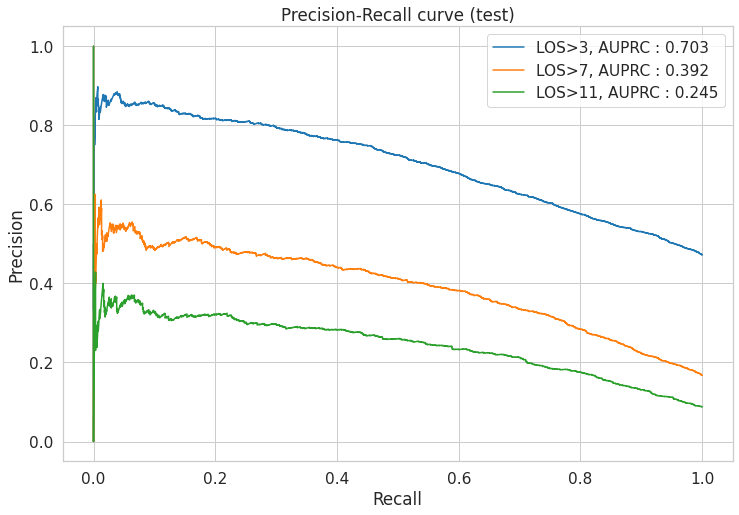

In [8]:
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_prediction_ordinal'
f, axs = plt.subplots(1, 1, figsize=(12, 8))

ordinal_perf_dict_list = []

perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_ordinal_regression/final_perf*n_states=5*.csv'))

perf_csvs = [ii for ii in perf_csvs if 'perc_labelled' not in ii]

valid_auprc_np_3 = np.zeros(len(perf_csvs))
test_auprc_np_3 = np.zeros(len(perf_csvs))
valid_auprc_np_7 = np.zeros(len(perf_csvs))
test_auprc_np_7 = np.zeros(len(perf_csvs))
valid_auprc_np_11 = np.zeros(len(perf_csvs))
test_auprc_np_11 = np.zeros(len(perf_csvs))

for ii, perf_csv in enumerate(perf_csvs):
    curr_perf_df = pd.read_csv(perf_csv)
    valid_auprc_np_3[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
    test_auprc_np_3[ii] = curr_perf_df['test_AUPRC_3'].values[-1]
    
    valid_auprc_np_7[ii] = curr_perf_df['valid_AUPRC_7'].values[-1]
    test_auprc_np_7[ii] = curr_perf_df['test_AUPRC_7'].values[-1]
    
    valid_auprc_np_11[ii] = curr_perf_df['valid_AUPRC_11'].values[-1]
    test_auprc_np_11[ii] = curr_perf_df['test_AUPRC_11'].values[-1]
    
    
best_ind = np.argmax(valid_auprc_np_3)
perf_df = pd.read_csv(perf_csvs[best_ind])
best_model_perf_csv = perf_csvs[best_ind]


x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH , 'X_test.npy')
y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')

best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

X_test = np.load(x_test_np_filename)
y_test = np.load(y_test_np_filename)


X_test = np.expand_dims(X_test, 1)

# standardize data for PC-HMM
key_list = ['train', 'valid', 'test']
data_dict = dict.fromkeys(key_list)
data_dict['train'] = (X_test, y_test)
data_dict['valid'] = (X_test, y_test)
data_dict['test'] = (X_test, y_test)
data = custom_regression_dataset(data_dict=data_dict)

# load the best PCHMM model
model = HMM(states=5,
            observation_dist='NormalWithMissing',
            predictor_dist='OrderedLogistic')

model.build(data)
model.model.load_weights(best_model_weights)

x_test, y_test = data.test().numpy()
z_test = model.hmm_model.predict(x_test)

y_test_pred_proba_NC = model._predictor(z_test).distribution.categorical_probs().numpy().squeeze()

y_test_N3, y_test_pred_proba_N3, test_auprc_3, test_roc_auc_3, y_test_N7, y_test_pred_proba_N7, test_auprc_7, test_roc_auc_7, y_test_N11, y_test_pred_proba_N11, test_auprc_11, test_roc_auc_11 = compute_binary_classification_perf(y_test, y_test_pred_proba_NC)

for min_los, y_test, y_test_pred_proba  in [(3, y_test_N3, y_test_pred_proba_N3),
                                            (7, y_test_N7, y_test_pred_proba_N7),
                                            (11, y_test_N11, y_test_pred_proba_N11)]:
    sns.set_context('notebook', font_scale=1.4)
    sns.set_style('whitegrid')
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
    axs.plot(recall, precision, label='LOS>%d, AUPRC : %.3f'%(min_los, perf_df['test_AUPRC_%s'%min_los].values[-1]))
    axs.set_ylabel("Precision")
    axs.set_xlabel("Recall")
    axs.set_title("Precision-Recall curve (test)")
    axs.legend()


    print('test AUPRC of best model for LOS classification > %d days: %.3f'%(min_los, 
                                                                             perf_df['test_AUPRC_%s'%min_los].values[-1]))
    print('test AUC of best model for LOS classification > %d days : %.3f'%(min_los, 
                                                                            perf_df['test AUC_%s'%min_los].values[-1]))
    
    ordinal_perf_dict_list.append({'min_los' : min_los,
                 'perc_labelled' : '100',
                 'test_AUC' : perf_df['test AUC_%s'%min_los].values[-1],
                 'test_AUPRC' : perf_df['test_AUPRC_%s'%min_los].values[-1]})
    
plt.show()

## Get the PC-HMM ordinal regression performance as a function of percent labelled sequences

In [9]:
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_prediction_ordinal'
for perc_labelled in perc_labelled_list:
    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_ordinal_regression/final_perf*perc_labelled=%s*n_states=5-*.csv'%perc_labelled))


    valid_auprc_np_3 = np.zeros(len(perf_csvs))
    test_auprc_np_3 = np.zeros(len(perf_csvs))
    valid_auprc_np_7 = np.zeros(len(perf_csvs))
    test_auprc_np_7 = np.zeros(len(perf_csvs))
    valid_auprc_np_11 = np.zeros(len(perf_csvs))
    test_auprc_np_11 = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np_3[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
        test_auprc_np_3[ii] = curr_perf_df['test_AUPRC_3'].values[-1]

        valid_auprc_np_7[ii] = curr_perf_df['valid_AUPRC_7'].values[-1]
        test_auprc_np_7[ii] = curr_perf_df['test_AUPRC_7'].values[-1]

        valid_auprc_np_11[ii] = curr_perf_df['valid_AUPRC_11'].values[-1]
        test_auprc_np_11[ii] = curr_perf_df['test_AUPRC_11'].values[-1]


    best_ind = np.argmax(valid_auprc_np_3)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]


    x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH , 'X_test.npy')
    y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')

    best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

    X_test = np.load(x_test_np_filename)
    y_test = np.load(y_test_np_filename)


    X_test = np.expand_dims(X_test, 1)

    # standardize data for PC-HMM
    key_list = ['train', 'valid', 'test']
    data_dict = dict.fromkeys(key_list)
    data_dict['train'] = (X_test, y_test)
    data_dict['valid'] = (X_test, y_test)
    data_dict['test'] = (X_test, y_test)
    data = custom_regression_dataset(data_dict=data_dict)

    # load the best PCHMM model
    model = HMM(states=5,
                observation_dist='NormalWithMissing',
                predictor_dist='OrderedLogistic')

    model.build(data)
    model.model.load_weights(best_model_weights)

    x_test, y_test = data.test().numpy()
    z_test = model.hmm_model.predict(x_test)

    y_test_pred_proba_NC = model._predictor(z_test).distribution.categorical_probs().numpy().squeeze()

    y_test_N3, y_test_pred_proba_N3, test_auprc_3, test_roc_auc_3, y_test_N7, y_test_pred_proba_N7, test_auprc_7, test_roc_auc_7, y_test_N11, y_test_pred_proba_N11, test_auprc_11, test_roc_auc_11 = compute_binary_classification_perf(y_test, y_test_pred_proba_NC)

    for min_los, y_test, y_test_pred_proba  in [(3, y_test_N3, y_test_pred_proba_N3),
                                                (7, y_test_N7, y_test_pred_proba_N7),
                                                (11, y_test_N11, y_test_pred_proba_N11)]:
        
        print('=======Percent labelled = %s========='%perc_labelled)
        print('test AUPRC of best model for LOS classification > %d days: %.3f'%(min_los, 
                                                                                 perf_df['test_AUPRC_%s'%min_los].values[-1]))
        print('test AUC of best model for LOS classification > %d days : %.3f'%(min_los, 
                                                                                perf_df['test AUC_%s'%min_los].values[-1]))
        
        ordinal_perf_dict_list.append({'min_los' : min_los,
                                       'perc_labelled' : perc_labelled,
                                       'test_AUC' : perf_df['test AUC_%s'%min_los].values[-1],
                                       'test_AUPRC' : perf_df['test_AUPRC_%s'%min_los].values[-1]}
                                     )

ordinal_perf_df = pd.DataFrame(ordinal_perf_dict_list)

Class dist 0.7228535956451151
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


=======Percent labelled = 1.2=========
test AUPRC of best model for LOS classification > 3 days: 0.604
test AUC of best model for LOS classification > 3 days : 0.631
=======Percent labelled = 1.2=========
test AUPRC of best model for LOS classification > 7 days: 0.277
test AUC of best model for LOS classification > 7 days : 0.662
=======Percent labelled = 1.2=========
test AUPRC of best model for LOS classification > 11 days: 0.167
test AUC of best model for LOS classification > 11 days : 0.688
Class dist 0.7228535956451151
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


=======Percent labelled = 3.7=========
test AUPRC of best model for LOS classification > 3 days: 0.647
test AUC of best model for LOS classification > 3 days : 0.676
=======Percent labelled = 3.7=========
test AUPRC of best model for LOS classification > 7 days: 0.323
test AUC of best model for LOS classification > 7 days : 0.712
=======Percent labelled = 3.7=========
test AUPRC of best model for LOS classification > 11 days: 0.197
test AUC of best model for LOS classification > 11 days : 0.735
Class dist 0.7228535956451151
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


=======Percent labelled = 11.1=========
test AUPRC of best model for LOS classification > 3 days: 0.669
test AUC of best model for LOS classification > 3 days : 0.696
=======Percent labelled = 11.1=========
test AUPRC of best model for LOS classification > 7 days: 0.345
test AUC of best model for LOS classification > 7 days : 0.729
=======Percent labelled = 11.1=========
test AUPRC of best model for LOS classification > 11 days: 0.206
test AUC of best model for LOS classification > 11 days : 0.744
Class dist 0.7228535956451151
Training data shape: (10471, 1, 24, 41)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 41) (41 channels).
  ' channels).')


=======Percent labelled = 33.3=========
test AUPRC of best model for LOS classification > 3 days: 0.688
test AUC of best model for LOS classification > 3 days : 0.711
=======Percent labelled = 33.3=========
test AUPRC of best model for LOS classification > 7 days: 0.372
test AUC of best model for LOS classification > 7 days : 0.752
=======Percent labelled = 33.3=========
test AUPRC of best model for LOS classification > 11 days: 0.243
test AUC of best model for LOS classification > 11 days : 0.770


## Get 20 state ordinal PC-HMM performance as a function of % labelled sequences

In [10]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
pchmm_20_state_ordinal_perf_dict_list = []
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_prediction_ordinal'
for min_los in [3, 7, 11]:
    for perc_labelled in perc_labelled_list:
        perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_ordinal_regression/final_perf*perc_labelled=%s*n_states=20-*.csv'%perc_labelled))
        
        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
            test_auprc_np[ii] = curr_perf_df['test_AUPRC_3'].values[-1]

        try:
            best_ind = np.argmax(valid_auprc_np)
            perf_df = pd.read_csv(perf_csvs[best_ind])
            best_model_perf_csv = perf_csvs[best_ind]

            test_roc_auc = perf_df['test AUC_%d'%min_los].values[-1]
            test_auprc = perf_df['test_AUPRC_%d'%min_los].values[-1]
        except:
            test_roc_auc=np.nan
            test_auprc=np.nan        


        best_ind = np.argmax(valid_auprc_np)
        perf_df = pd.read_csv(perf_csvs[best_ind])
        best_model_perf_csv = perf_csvs[best_ind]
        print(best_model_perf_csv)
        pchmm_20_state_ordinal_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

pchmm_20_state_ordinal_perf_df = pd.DataFrame(pchmm_20_state_ordinal_perf_dict_list)

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.001-seed=675-init_strategy=kmeans-batch_size=256-predictor_l2_penalty=0.1-perc_labelled=1.2-n_states=20-lamb=1000.csv
================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.580
test AUROC : 0.617
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.005-seed=17-init_strategy=kmeans-batch_size=128-predictor_l2_penalty=0.1-perc_labelled=3.7-n_states=20-lamb=1000.csv
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.640
test AUROC : 0.668
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.005-seed=282-init_strategy=kmeans-bat

## Get performance of GRU-D classification as a function of % labelled sequences

In [11]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
grud_perf_dict_list = []
for min_los in [3, 7, 11]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/GRUD/los_classification/final_perf*min_los=%d*perc_labelled=%s*.csv'%(min_los, perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
            test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

        # curr_perf_df
        best_ind = np.argmax(valid_auprc_np)
        perf_df = pd.read_csv(perf_csvs[best_ind])
        best_model_perf_csv = perf_csvs[best_ind]
        
        test_roc_auc = perf_df['test_AUC']
        test_auprc = perf_df['test_AUPRC']
        
        
        grud_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

grud_perf_df = pd.DataFrame(grud_perf_dict_list)

================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.530
test AUROC : 0.559
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.547
test AUROC : 0.586
================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.580
test AUROC : 0.618
================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.600
test AUROC : 0.639
================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.625
test AUROC : 0.664
================LOS > 7 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.217
test AUROC : 0.596
================LOS > 7 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.231
test AUROC : 0.620
================LOS > 7 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.264
test AUROC : 0.654
=====

## Get the MixMatch Performance as a function of % labelled sequences

In [12]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
mixmatch_perf_dict_list = []
for min_los in [3, 7, 11]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/MixMatch/los_classification/final_perf*min_los=%d*perc_labelled=%s*.csv'%(min_los, perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
            test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

        # curr_perf_df
        best_ind = np.argmax(valid_auprc_np)
        perf_df = pd.read_csv(perf_csvs[best_ind])
        best_model_perf_csv = perf_csvs[best_ind]
        
        test_roc_auc = perf_df['test_AUROC'].values[-1]
        test_auprc = perf_df['test_AUPRC'].values[-1]
        
        
        mixmatch_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

mixmatch_perf_df = pd.DataFrame(mixmatch_perf_dict_list)

================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.507
test AUROC : 0.507
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.554
test AUROC : 0.584
================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.554
test AUROC : 0.578
================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.568
test AUROC : 0.607
================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.593
test AUROC : 0.628
================LOS > 7 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.204
test AUROC : 0.548
================LOS > 7 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.220
test AUROC : 0.551
================LOS > 7 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.243
test AUROC : 0.614
=====

## Get FixMatch performance as a function of % labelled sequences

In [13]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
fixmatch_perf_dict_list = []
for min_los in [3, 7, 11]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/FixMatch/los_classification/final_perf*min_los=%d*perc_labelled=%s*.csv'%(min_los, perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
            test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

        # curr_perf_df
        best_ind = np.argmax(valid_auprc_np)
        perf_df = pd.read_csv(perf_csvs[best_ind])
        best_model_perf_csv = perf_csvs[best_ind]
        
        test_roc_auc = perf_df['test_AUROC'].values[-1]
        test_auprc = perf_df['test_AUPRC'].values[-1]
        
        
        fixmatch_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

fixmatch_perf_df = pd.DataFrame(fixmatch_perf_dict_list)

================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.508
test AUROC : 0.512
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.527
test AUROC : 0.541
================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.512
test AUROC : 0.536
================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.494
test AUROC : 0.497
================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.502
test AUROC : 0.509
================LOS > 7 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.201
test AUROC : 0.539
================LOS > 7 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.217
test AUROC : 0.560
================LOS > 7 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.210
test AUROC : 0.568
=====

## Get BRITS performance as a function of % labelled sequences

In [14]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
brits_perf_dict_list = []
for min_los in [3, 7, 11]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/BRITS/los_classification/final_perf*min_los=%d*perc_labelled=%s*.csv'%(min_los, perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['AUPRC_valid'].values[-1]
            test_auprc_np[ii] = curr_perf_df['AUPRC_test'].values[-1]

        # curr_perf_df
        try:
            best_ind = np.argmax(valid_auprc_np)
            perf_df = pd.read_csv(perf_csvs[best_ind])
            best_model_perf_csv = perf_csvs[best_ind]

            test_roc_auc = perf_df['AUC_test'].values[-1]
            test_auprc = perf_df['AUPRC_test'].values[-1]
        except:
            test_roc_auc=np.nan
            test_auprc=np.nan


        brits_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

brits_perf_df = pd.DataFrame(brits_perf_dict_list)

================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.510
test AUROC : 0.543
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.523
test AUROC : 0.551
================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.569
test AUROC : 0.599
================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.598
test AUROC : 0.627
================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.679
test AUROC : 0.699
================LOS > 7 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.210
test AUROC : 0.569
================LOS > 7 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.200
test AUROC : 0.565
================LOS > 7 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.209
test AUROC : 0.563
=====

## Get GRU-D ordinal regression performance as a function of % labelled

In [15]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
grud_ordinal_perf_dict_list = []
for min_los in [3, 7, 11]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/GRUD/los_ordinal_regression/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
            test_auprc_np[ii] = curr_perf_df['test_AUPRC_3'].values[-1]

        # curr_perf_df
        try:
            best_ind = np.argmax(valid_auprc_np)
            perf_df = pd.read_csv(perf_csvs[best_ind])
            best_model_perf_csv = perf_csvs[best_ind]

            test_roc_auc = perf_df['test AUC_%d'%min_los].values[-1]
            test_auprc = perf_df['test_AUPRC_%d'%min_los].values[-1]
        except:
            test_roc_auc=np.nan
            test_auprc=np.nan


        grud_ordinal_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

grud_ordinal_perf_df = pd.DataFrame(grud_ordinal_perf_dict_list)

================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.555
test AUROC : 0.595
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.591
test AUROC : 0.630
================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.578
test AUROC : 0.616
================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.616
test AUROC : 0.639
================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.639
test AUROC : 0.656
================LOS > 7 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.238
test AUROC : 0.621
================LOS > 7 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.267
test AUROC : 0.663
================LOS > 7 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.278
test AUROC : 0.663
=====

## Get BRITS ordinal regression performance as a function of % labelled sequences

In [6]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
brits_ordinal_perf_dict_list = []
for min_los in [3, 7, 11]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/BRITS/los_ordinal_regression/*perc_labelled=%s*.csv'%(perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['AUPRC_valid_3'].values[-1]
            test_auprc_np[ii] = curr_perf_df['AUPRC_test_3'].values[-1]

        # curr_perf_df
        try:
            best_ind = np.argmax(valid_auprc_np)
            perf_df = pd.read_csv(perf_csvs[best_ind])
            best_model_perf_csv = perf_csvs[best_ind]

            test_roc_auc = perf_df['AUC_test_%d'%min_los].values[-1]
            test_auprc = perf_df['AUPRC_test_%d'%min_los].values[-1]
        except:
            test_roc_auc=np.nan
            test_auprc=np.nan


        brits_ordinal_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

brits_ordinal_perf_df = pd.DataFrame(brits_ordinal_perf_dict_list)

================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.489
test AUROC : 0.515
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.504
test AUROC : 0.531
================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.505
test AUROC : 0.542
================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.519
test AUROC : 0.554
================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.508
test AUROC : 0.536
================LOS > 7 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.173
test AUROC : 0.503
================LOS > 7 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.187
test AUROC : 0.539
================LOS > 7 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.180
test AUROC : 0.535
=====

## Plot ordinal regression vs binary classification SSL performance 

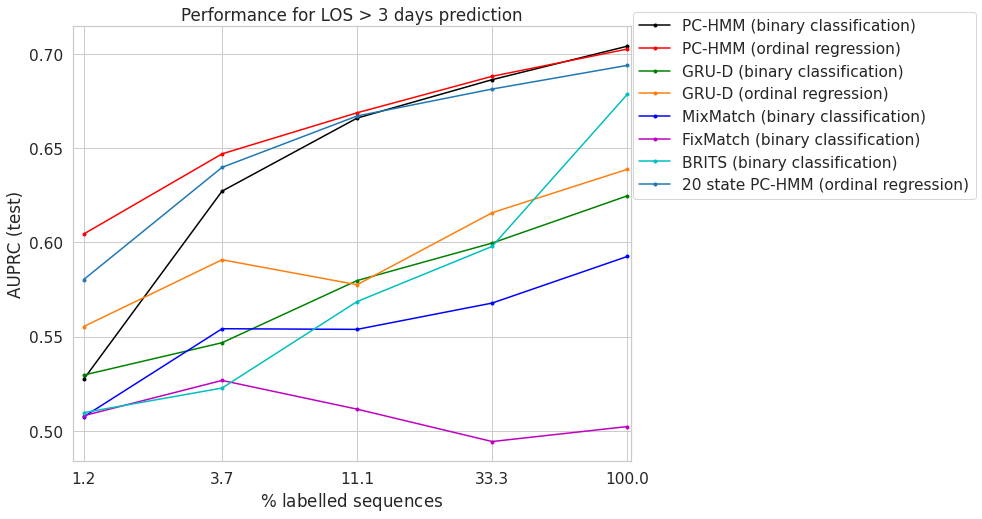

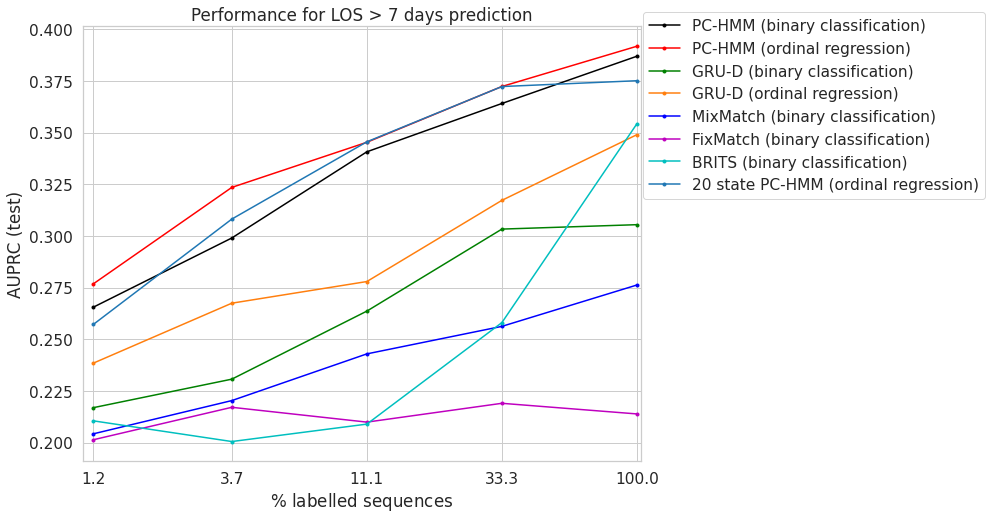

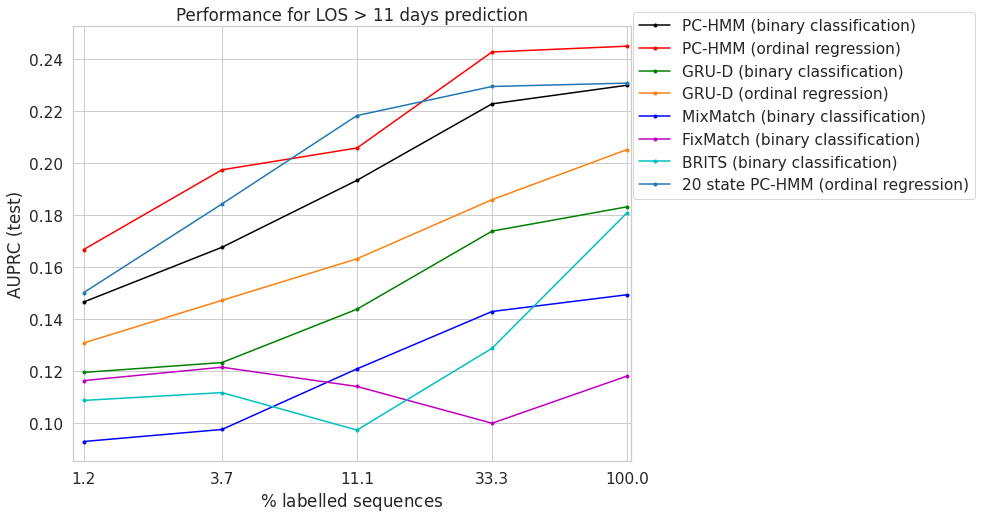

In [18]:
ordinal_perf_df['perc_labelled'] = ordinal_perf_df['perc_labelled'].astype(float)
bc_perf_df['perc_labelled'] = bc_perf_df['perc_labelled'].astype(float)
grud_perf_df['perc_labelled'] = grud_perf_df['perc_labelled'].astype(float)
mixmatch_perf_df['perc_labelled'] = mixmatch_perf_df['perc_labelled'].astype(float)
fixmatch_perf_df['perc_labelled'] = fixmatch_perf_df['perc_labelled'].astype(float)
brits_perf_df['perc_labelled'] = brits_perf_df['perc_labelled'].astype(float)
grud_ordinal_perf_df['perc_labelled'] = grud_ordinal_perf_df['perc_labelled'].astype(float)
pchmm_20_state_ordinal_perf_df['perc_labelled'] = pchmm_20_state_ordinal_perf_df['perc_labelled'].astype(float)

for min_los in [3, 7, 11]:
    f, axs = plt.subplots(1, 1, figsize=(10, 8))
    sns.set_context('notebook', font_scale=1.4)
    sns.set_style('whitegrid')
    curr_ordinal_perf_df = ordinal_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_bc_perf_df = bc_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_grud_perf_df = grud_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_mixmatch_perf_df = mixmatch_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_fixmatch_perf_df = fixmatch_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_brits_perf_df = brits_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_grud_ordinal_perf_df = grud_ordinal_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_pchmm_20_state_ordinal_perf_df = pchmm_20_state_ordinal_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    
    
    perc_labelled = curr_bc_perf_df['perc_labelled'].values
    test_auprc_bc_np = curr_bc_perf_df['test_AUPRC'].values
    test_auprc_ordinal_np = curr_ordinal_perf_df['test_AUPRC'].values
    test_auprc_grud = curr_grud_perf_df['test_AUPRC'].values
    test_auprc_mixmatch = curr_mixmatch_perf_df['test_AUPRC'].values
    test_auprc_fixmatch = curr_fixmatch_perf_df['test_AUPRC'].values
    test_auprc_brits = curr_brits_perf_df['test_AUPRC'].values
    test_auprc_grud_ordinal = curr_grud_ordinal_perf_df['test_AUPRC'].values
    test_auprc_pchmm_20_state_ordinal = curr_pchmm_20_state_ordinal_perf_df['test_AUPRC'].values
    
    
    axs.plot(perc_labelled, test_auprc_bc_np, 'k.-', label='PC-HMM (binary classification)')
    axs.plot(perc_labelled, test_auprc_ordinal_np, 'r.-', label='PC-HMM (ordinal regression)')
    axs.plot(perc_labelled, test_auprc_grud, 'g.-', label='GRU-D (binary classification)')
    axs.plot(perc_labelled, test_auprc_grud_ordinal, '.-', c='tab:orange',label='GRU-D (ordinal regression)')
    axs.plot(perc_labelled, test_auprc_mixmatch, 'b.-', label='MixMatch (binary classification)')
    axs.plot(perc_labelled, test_auprc_fixmatch, 'm.-', label='FixMatch (binary classification)')
    axs.plot(perc_labelled, test_auprc_brits, 'c.-', label='BRITS (binary classification)')
    axs.plot(perc_labelled, test_auprc_pchmm_20_state_ordinal, '.-', 
             label='20 state PC-HMM (ordinal regression)')
    
    axs.legend(bbox_to_anchor=(0.99, 1.05))
    axs.set_title('Performance for LOS > %s days prediction'%min_los)
    
    axs.set_xscale('log')    
    axs.set_xticks(perc_labelled)
    axs.set_xticklabels(perc_labelled)
    
    axs.set_xlim([1.1, 103])
    
    axs.set_ylabel('AUPRC (test)')
    axs.set_xlabel(r'$\%$ labelled sequences')
    f.savefig('perf_los_geq_%s_days.pdf'%min_los, bbox_inches='tight')
    f.savefig('perf_los_geq_%s_days.png'%min_los, bbox_inches='tight')
    plt.show()
    

## Compare performance of various PC-HMM ordinal regression models across different number of states

In [17]:
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_prediction_ordinal'
# f, axs = plt.subplots(1, 1, figsize=(12, 8))

states_list = ['5', '10', '20', '40']
# perc_labelled_list = ['1.2', '3.7', '11.1', '33.3']
train_auprc_per_state_np = np.zeros(len(states_list))
val_auprc_per_state_np = np.zeros(len(states_list))
test_auprc_per_state_np = np.zeros(len(states_list))
# for perc_labelled in perc_labelled_list:
for jj, n_states in enumerate(states_list):
    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_ordinal_regression/final_perf*n_states=%s*.csv'%(n_states)))

    # perf_csvs = [ii for ii in perf_csvs if 'perc_labelled' not in ii]

    train_auprc_np_3 = np.zeros(len(perf_csvs))
    valid_auprc_np_3 = np.zeros(len(perf_csvs))
    test_auprc_np_3 = np.zeros(len(perf_csvs))
    valid_auprc_np_7 = np.zeros(len(perf_csvs))
    test_auprc_np_7 = np.zeros(len(perf_csvs))
    valid_auprc_np_11 = np.zeros(len(perf_csvs))
    test_auprc_np_11 = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        train_auprc_np_3[ii] = curr_perf_df['train_AUPRC_3'].values[-1]
        valid_auprc_np_3[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
        test_auprc_np_3[ii] = curr_perf_df['test_AUPRC_3'].values[-1]

        valid_auprc_np_7[ii] = curr_perf_df['valid_AUPRC_7'].values[-1]
        test_auprc_np_7[ii] = curr_perf_df['test_AUPRC_7'].values[-1]

        valid_auprc_np_11[ii] = curr_perf_df['valid_AUPRC_11'].values[-1]
        test_auprc_np_11[ii] = curr_perf_df['test_AUPRC_11'].values[-1]


    best_ind_tr = np.argmax(train_auprc_np_3)
    best_ind_va = np.argmax(valid_auprc_np_3)
    perf_df = pd.read_csv(perf_csvs[best_ind_tr])


    train_auprc_per_state_np[jj] = train_auprc_np_3[best_ind_tr]
    val_auprc_per_state_np[jj] = valid_auprc_np_3[best_ind_va]
    test_auprc_per_state_np[jj] = test_auprc_np_3[best_ind_va]
    print('Train AUPRC for n_states = %s : %.3f'%(n_states, train_auprc_np_3[best_ind_tr]))
    print('Val AUPRC for n_states = %s : %.3f'%(n_states, valid_auprc_np_3[best_ind_va]))
    print('Test AUPRC for n_states = %s : %.3f'%(n_states, test_auprc_np_3[best_ind_va]))
    best_model_perf_csv = perf_csvs[best_ind_va]
    print(best_model_perf_csv)

Train AUPRC for n_states = 5 : 0.847
Val AUPRC for n_states = 5 : 0.683
Test AUPRC for n_states = 5 : 0.703
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.01-seed=152-init_strategy=kmeans-batch_size=128-predictor_l2_penalty=0-n_states=5-lamb=100.csv
Train AUPRC for n_states = 10 : 0.891
Val AUPRC for n_states = 10 : 0.681
Test AUPRC for n_states = 10 : 0.701
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.01-seed=124-init_strategy=kmeans-batch_size=128-predictor_l2_penalty=0-n_states=10-lamb=50.csv
Train AUPRC for n_states = 20 : 0.960
Val AUPRC for n_states = 20 : 0.679
Test AUPRC for n_states = 20 : 0.694
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/final_perf_semi-supervised-pchmm-lr=0.

Text(0.5, 1.0, 'Prediction of LOS > 3 with ordinal model')

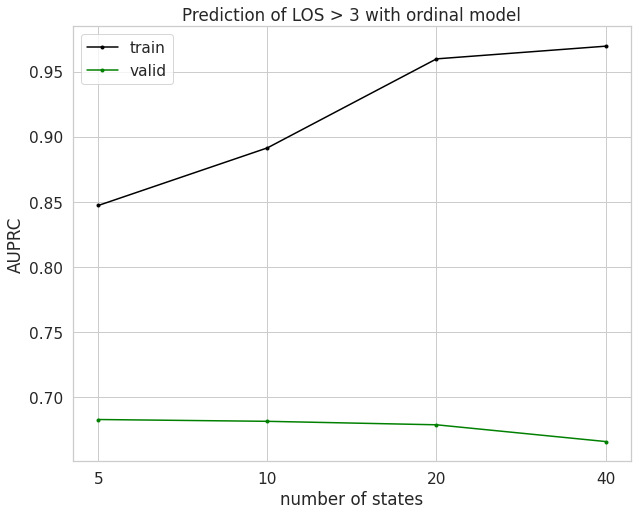

In [18]:
f, axs = plt.subplots(1, 1, figsize=(10, 8))
sns.set_context('notebook', font_scale=1.4)
sns.set_style('whitegrid')
axs.plot(np.array(states_list), train_auprc_per_state_np, 'k.-', label='train')
axs.plot(np.array(states_list), val_auprc_per_state_np, 'g.-', label='valid')
# axs.plot(np.array(states_list), test_auprc_per_state_np, 'b.-', label='test')
axs.legend()
axs.set_ylabel('AUPRC')
axs.set_xlabel('number of states')
axs.set_title('Prediction of LOS > 3 with ordinal model')

## plot the performance as a function of penalty

In [19]:
# penalty_list = ['0', '1e-07', '1e-05', '0.001', '0.1', '0.25', '0.5', '1', '5', '10']
penalty_list = ['0', '1e-07', '1e-05', '0.001', '0.005', '0.1', '0.25', '0.5', '1', '5', '10']
test_perf_per_penalty = []
val_perf_per_penalty = []
train_perf_per_penalty = []
for pen in penalty_list:
    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_ordinal_regression/final_perf*predictor_l2_penalty=%s-*n_states=20*.csv'%pen))
    
    train_auprc_np_3 = np.zeros(len(perf_csvs))
    valid_auprc_np_3 = np.zeros(len(perf_csvs))
    test_auprc_np_3 = np.zeros(len(perf_csvs))
    
    train_auprc_np_7 = np.zeros(len(perf_csvs))
    valid_auprc_np_7 = np.zeros(len(perf_csvs))
    test_auprc_np_7 = np.zeros(len(perf_csvs))
    valid_auprc_np_11 = np.zeros(len(perf_csvs))
    test_auprc_np_11 = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        train_auprc_np_3[ii] = curr_perf_df['train_AUPRC_3'].values[-1]
        valid_auprc_np_3[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
        test_auprc_np_3[ii] = curr_perf_df['test_AUPRC_3'].values[-1]
        
        train_auprc_np_7[ii] = curr_perf_df['train_AUPRC_7'].values[-1]
        valid_auprc_np_7[ii] = curr_perf_df['valid_AUPRC_7'].values[-1]
        test_auprc_np_7[ii] = curr_perf_df['test_AUPRC_7'].values[-1]

        valid_auprc_np_11[ii] = curr_perf_df['valid_AUPRC_11'].values[-1]
        test_auprc_np_11[ii] = curr_perf_df['test_AUPRC_11'].values[-1]


    best_ind = np.argmax(valid_auprc_np_3)
    val_perf_per_penalty.append(valid_auprc_np_3[best_ind])
    test_perf_per_penalty.append(test_auprc_np_3[best_ind])
    train_perf_per_penalty.append(train_auprc_np_3[best_ind])

Text(0.5, 1.0, 'Prediction of LOS > 3 with 20 state PC-HMM ordinal model')

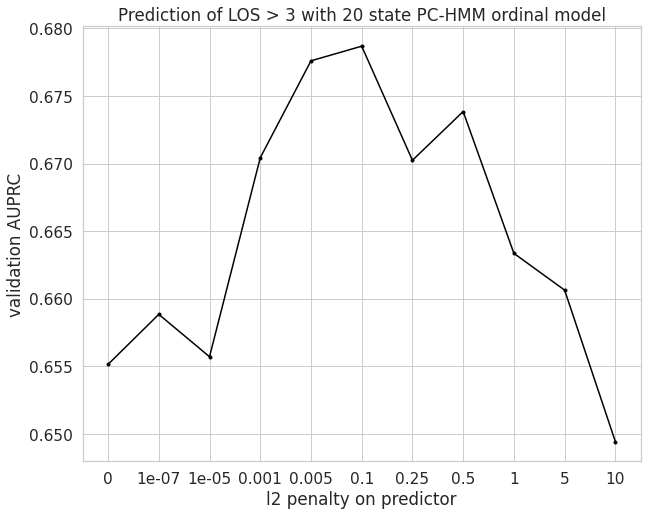

In [20]:
f, axs = plt.subplots(1, 1, figsize=(10, 8))
sns.set_context('notebook', font_scale=1.4)
sns.set_style('whitegrid')
axs.plot(np.array(penalty_list), np.array(val_perf_per_penalty), 'k.-')
axs.set_ylabel('validation AUPRC')
axs.set_xlabel('l2 penalty on predictor')
axs.set_title('Prediction of LOS > 3 with 20 state PC-HMM ordinal model')

In [45]:
test_perf_per_penalty

[0.5434338285561435, 0.5613730226929461]

## Plot the loss plots for the 20 state PC-HMM

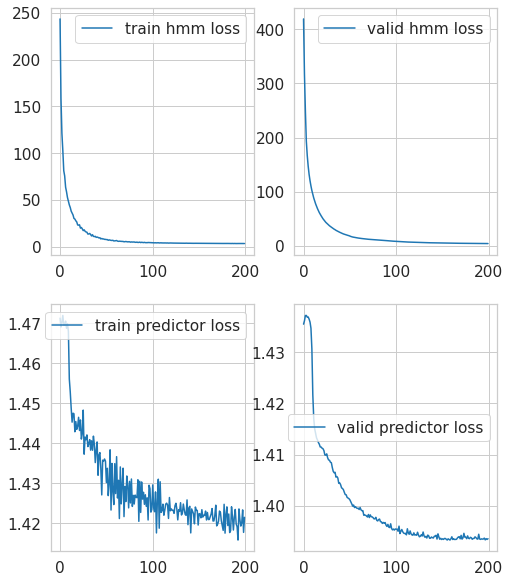

In [21]:
save_dir = "/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/MIMIC-IV/results/PCHMM/los_ordinal_regression/"
hist_csv = os.path.join(save_dir, "semi-supervised-pchmm-lr=0.005-seed=194-init_strategy=kmeans-batch_size=128-predictor_l2_penalty=0.1-perc_labelled=100-n_states=20-lamb=100.csv")

f, axs = plt.subplots(2, 2, figsize=(8, 10))
axs_list = axs.flatten()
lamb = int(hist_csv.replace('.csv', '').split('lamb=')[-1])

final_hist_df = pd.read_csv(hist_csv)

epochs = range(len(final_hist_df))
train_hmm_loss = final_hist_df['hmm_model_loss'].values
val_hmm_loss = final_hist_df['val_hmm_model_loss'].values

train_predictor_loss = final_hist_df['predictor_loss'].values/lamb
val_predictor_loss = final_hist_df['val_predictor_loss'].values/lamb

axs_list[0].plot(epochs, train_hmm_loss, label='train hmm loss')
axs_list[1].plot(epochs, val_hmm_loss, label='valid hmm loss')

axs_list[2].plot(epochs, train_predictor_loss, label='train predictor loss')
axs_list[3].plot(epochs, val_predictor_loss, label='valid predictor loss')

for ax in axs_list:
    ax.legend()